In [1]:
import torch
import torchvision.transforms as transforms
from torchvision import datasets

In [2]:
train = datasets.MNIST(
                            root='data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test = datasets.MNIST(
                           root='data', 
                           train=False, 
                           transform=transforms.ToTensor())

In [3]:
print(train.train_data.size())

torch.Size([60000, 28, 28])


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [4]:
print(train.train_labels.size())

torch.Size([60000])


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [5]:
print(train.targets.size())

torch.Size([60000])


In [6]:
print(test.test_labels.size())

torch.Size([10000])


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [7]:
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


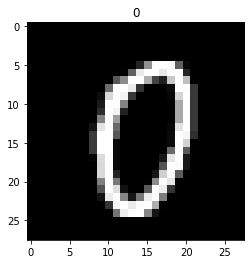

In [8]:
plt.imshow(train.train_data.data[1000], cmap='gray')
plt.title('%i' % train.targets[1000])
plt.show()

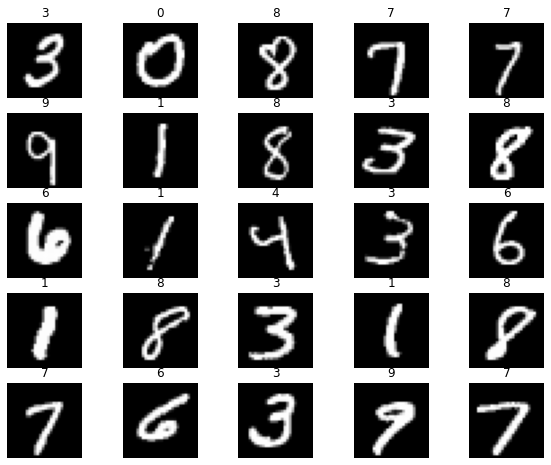

In [9]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train), size=(1,)).item()
    img, label = train[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [10]:
batch_size = 100
n_iters = 3000
#num_epochs = n_iters / (len(train_dataset) / batch_size)
#num_epochs = int(num_epochs)

loaders = {
'train_loader' : torch.utils.data.DataLoader(dataset=train, 
                                           batch_size=batch_size, 
                                           shuffle=True,
                                           num_workers=1),

'test_loader' : torch.utils.data.DataLoader(dataset=test, 
                                          batch_size=batch_size, 
                                          shuffle=True,
                                          num_workers=1),
}
loaders

{'test_loader': <torch.utils.data.dataloader.DataLoader at 0x7f670193fcd0>,
 'train_loader': <torch.utils.data.dataloader.DataLoader at 0x7f670193fc10>}

In [11]:
import torch.nn as nn

In [12]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.relu1 = nn.ReLU()
        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.relu2 = nn.ReLU()
        # Max pool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        # Fully connected 1 (readout)
        self.fc1 = nn.Linear(32 * 7 * 7, 10) 
    
    def forward(self, x):
        # Convolution 1
        out = self.cnn1(x)
        out = self.relu1(out)
        # Max pool 1
        out = self.maxpool1(out)
        # Convolution 2 
        out = self.cnn2(out)
        out = self.relu2(out)
        # Max pool 2 
        out = self.maxpool2(out)
        # Resize
        # Original size: (100, 32, 7, 7)
        # out.size(0): 100
        # New out size: (100, 32*7*7)
        out = out.view(out.size(0), -1)
        # Linear function (readout)
        out = self.fc1(out)
        return out

In [13]:
model = CNNModel()
print(model)

CNNModel(
  (cnn1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=10, bias=True)
)


In [14]:
loss_function = nn.CrossEntropyLoss()

In [15]:
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

In [16]:
# Train the model
total_step = len(loaders['train_loader'])
total_step

600

In [17]:
iter = 0
num_epochs=10
losses = []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(loaders['train_loader']):
        # Load images
        images = images.requires_grad_()
        # Clear gradients wrt parameters
        optimizer.zero_grad()
        # Forward pass to get output/logits
        outputs = model(images)
        # Calculate Loss: softmax --> cross entropy loss
        loss = loss_function(outputs, labels)
        # Getting gradients wrt parameters
        loss.backward()
        # Updating parameters
        optimizer.step() 
        iter += 1
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in loaders['test_loader']:
                # Load images
                images = images.requires_grad_()
                # Forward pass only to get logits/output
                outputs = model(images)
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                # Total number of labels
                total += labels.size(0)
                # Total correct predictions
                correct += (predicted == labels).sum()
            accuracy = 100 * correct / total
            losses.append(loss.item())
            # Print Loss
            print('Epoch [{}/{}], Step [{}/{}], Iteration: {}, Loss: {:.4f}, Accuracy: {:.4f}'.format(epoch + 1, num_epochs, i + 1, total_step, iter, loss.item(), accuracy))                  

Epoch [1/10], Step [500/600], Iteration: 500, Loss: 0.4439, Accuracy: 88.7200
Epoch [2/10], Step [400/600], Iteration: 1000, Loss: 0.3025, Accuracy: 92.7300
Epoch [3/10], Step [300/600], Iteration: 1500, Loss: 0.1609, Accuracy: 94.9400
Epoch [4/10], Step [200/600], Iteration: 2000, Loss: 0.0600, Accuracy: 95.8500
Epoch [5/10], Step [100/600], Iteration: 2500, Loss: 0.0907, Accuracy: 96.5800
Epoch [5/10], Step [600/600], Iteration: 3000, Loss: 0.1518, Accuracy: 96.7500
Epoch [6/10], Step [500/600], Iteration: 3500, Loss: 0.0961, Accuracy: 96.7200
Epoch [7/10], Step [400/600], Iteration: 4000, Loss: 0.0760, Accuracy: 97.5900
Epoch [8/10], Step [300/600], Iteration: 4500, Loss: 0.1244, Accuracy: 97.7500
Epoch [9/10], Step [200/600], Iteration: 5000, Loss: 0.0580, Accuracy: 97.8000
Epoch [10/10], Step [100/600], Iteration: 5500, Loss: 0.0399, Accuracy: 97.8300
Epoch [10/10], Step [600/600], Iteration: 6000, Loss: 0.0968, Accuracy: 97.6100


In [18]:
losses

[0.4439300298690796,
 0.30253949761390686,
 0.1608508676290512,
 0.060013774782419205,
 0.09065958112478256,
 0.15183621644973755,
 0.09608349949121475,
 0.07601616531610489,
 0.12437918037176132,
 0.05795404314994812,
 0.03988690674304962,
 0.09680425375699997]

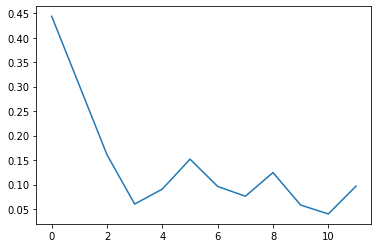

In [19]:
plt.plot(losses)

In [20]:
model_1 = CNNModel()

In [21]:
learning_rate = 0.01
momentum=0.9
optimizer_1 = torch.optim.SGD(model_1.parameters(), lr=learning_rate, momentum=momentum)  

In [22]:
losses_1 = []
iter = 0
num_epochs=10
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(loaders['train_loader']):
        # Load images
        images = images.requires_grad_()
        # Clear gradients wrt parameters
        optimizer_1.zero_grad()
        # Forward pass to get output/logits
        outputs = model_1(images)
        # Calculate Loss: softmax --> cross entropy loss
        loss = loss_function(outputs, labels)
        # Getting gradients w.r.t. parameters
        loss.backward()
        # Updating parameters
        optimizer_1.step()
        iter += 1
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in loaders['test_loader']:
                # Load images
                images = images.requires_grad_()
                # Forward pass only to get logits/output
                outputs = model_1(images)
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                # Total number of labels
                total += labels.size(0)
                # Total correct predictions
                correct += (predicted == labels).sum()
            accuracy = 100 * correct / total
            losses_1.append(loss.item())
            # Print Loss
            print('Epoch [{}/{}], Step [{}/{}], Iteration: {}, Loss: {:.4f}, Accuracy: {:.4f}'.format(epoch + 1, num_epochs, i + 1, total_step, iter, loss.item(), accuracy))

Epoch [1/10], Step [500/600], Iteration: 500, Loss: 0.1214, Accuracy: 97.5400
Epoch [2/10], Step [400/600], Iteration: 1000, Loss: 0.0500, Accuracy: 98.0200
Epoch [3/10], Step [300/600], Iteration: 1500, Loss: 0.0176, Accuracy: 98.4300
Epoch [4/10], Step [200/600], Iteration: 2000, Loss: 0.0159, Accuracy: 98.7600
Epoch [5/10], Step [100/600], Iteration: 2500, Loss: 0.0662, Accuracy: 98.9700
Epoch [5/10], Step [600/600], Iteration: 3000, Loss: 0.0086, Accuracy: 98.7100
Epoch [6/10], Step [500/600], Iteration: 3500, Loss: 0.1708, Accuracy: 98.9800
Epoch [7/10], Step [400/600], Iteration: 4000, Loss: 0.0599, Accuracy: 98.9700
Epoch [8/10], Step [300/600], Iteration: 4500, Loss: 0.0458, Accuracy: 98.8700
Epoch [9/10], Step [200/600], Iteration: 5000, Loss: 0.0359, Accuracy: 98.9300
Epoch [10/10], Step [100/600], Iteration: 5500, Loss: 0.0236, Accuracy: 98.9900
Epoch [10/10], Step [600/600], Iteration: 6000, Loss: 0.0089, Accuracy: 98.9100


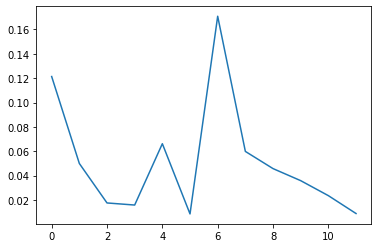

In [23]:
plt.plot(losses_1)

In [24]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import pandas as pd

Accuracy score: 0.976100


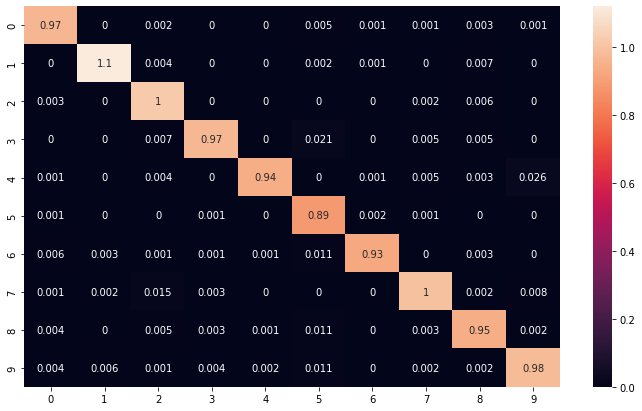

In [25]:
def predictions(model, test_loader):
    model.eval()
    actuals = []
    predictions = []
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            prediction = output.argmax(dim=1, keepdim=True)
            actuals.extend(target.view_as(prediction))
            predictions.extend(prediction)
    return [i.item() for i in actuals], [i.item() for i in predictions]   
actuals, predictions = predictions(model, loaders['test_loader'])
print('Accuracy score: %f' % accuracy_score(actuals, predictions))
cf=confusion_matrix(actuals, predictions)
df_cm = pd.DataFrame(cf/np.sum(cf) *10)
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True)

Accuracy score with Momentum: 0.989100


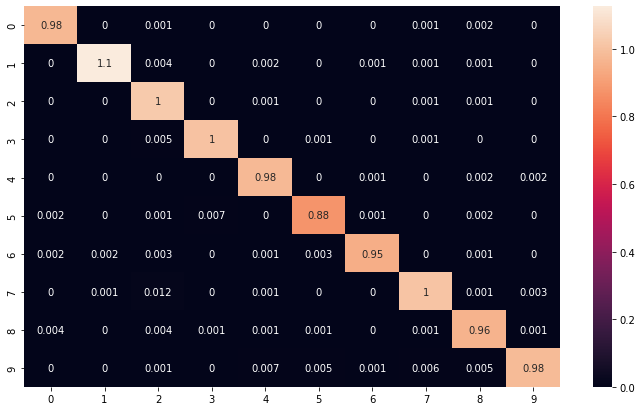

In [30]:
actuals_1, predictions_1 = predictions(model_1, loaders['test_loader'])    
print('Accuracy score with Momentum: %f' % accuracy_score(actuals_1, predictions_1))
cf_1=confusion_matrix(actuals_1, predictions_1)
df_cm_1 = pd.DataFrame(cf_1/np.sum(cf_1) *10)
plt.figure(figsize = (12,7))
sns.heatmap(df_cm_1, annot=True)

As we can see that after adding momentum=0.9, the accuracy of the model get improved. Accuracy score without momentum is 0.976100 while Accuracy score with Momentum is 0.989100